In [8]:
#Upload train file
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [2]:
#Upload test file
uploaded = files.upload()

Saving test.csv to test (1).csv


In [0]:
#Import libraries
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
from sklearn import metrics
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report

In [63]:
#Load and view dataset
df_train = pd.read_csv('train.csv')
print(df_train.head())
print("="*50)
df_test = pd.read_csv('test.csv')
print(df_test.head())

   tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1
   tweet_id                                              tweet
0      7506  Audience Q: What prototyping tools do you use?...
1      7992  At SXSW? Send Your Best Photos &amp; Videos to...
2       247  @mention  and here's a pic of you winning your...
3      7688  Google Marissa Mayer: mobile phone as a cursor...
4      3294    #SXSW Google maps is even cooler than I thought


In [0]:
#we make text lower case and leave only letters from a-z and digits
df_train['tweet'] = df_train['tweet'].astype(str)
df_train['tweet'] = df_train['tweet'].str.lower()
df_train['tweet'] = df_train['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

df_test['tweet'] = df_test['tweet'].astype(str)
df_test['tweet'] = df_test['tweet'].str.lower()
df_test['tweet'] = df_test['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

In [0]:
#Specify parameters for modelling
vocab_size = 50000
embedding_dim = 100
trunc_type='post'
oov_tok = "<OOV>"
training_size = len(df_train['tweet'])
test_portion = 0.2

In [66]:
#Find tweet with max_length
max_length = max([len(s.split()) for s in df_train['tweet']])
max_length

33

In [0]:
#Define X and Y
X = df_train['tweet']
y = df_train['sentiment']

In [0]:
#Split data into X_train, X_test, y_train, y_test
X_train, X_validation, y_train, y_validation = tts(X, y, test_size = 0.2, random_state = 42)

#Tokenize X_train
tokenizer = Tokenizer(oov_token=oov_tok, num_words=vocab_size)
tokenizer.fit_on_texts(X_train.values)
word_index = tokenizer.word_index

#Convert tweets to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_validation = tokenizer.texts_to_sequences(X_validation)

#Pad train sequences
X_train = pad_sequences(X_train, max_length, truncating=trunc_type, padding = 'post')
X_validation = pad_sequences(X_validation, max_length, truncating=trunc_type, padding = 'post')

In [69]:
#View shape of X_train and X_test
print(X_train.shape)
print(X_validation.shape)

(5819, 33)
(1455, 33)


In [70]:
#Use pretrained Glove embeddings for prediction
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-18 10:53:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  86.1MB/s    in 3.8s    

2020-05-18 10:53:12 (86.1 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
#Build Model architecture
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(LSTM(256, dropout= 0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(128, dropout= 0.2)),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [82]:
#View model summary
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 33, 100)           5000100   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 33, 512)           731136    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               656384    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 44        
Total params: 6,390,234
Trainable params: 6,390,234
Non-trainable params: 0
____________________________________________

In [0]:
#Specify weights for classes
weights = {0: 16, 1: 1.7, 2: 3, 3: 59}

In [85]:
#Fit model on X_train, y_train
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_validation, y_validation), verbose=2, batch_size = 32)

Epoch 1/200
182/182 - 9s - loss: 1.3659 - accuracy: 0.4936 - val_loss: 1.3299 - val_accuracy: 0.5986
Epoch 2/200
182/182 - 9s - loss: 1.2025 - accuracy: 0.5857 - val_loss: 0.8698 - val_accuracy: 0.5986
Epoch 3/200
182/182 - 9s - loss: 0.8729 - accuracy: 0.6149 - val_loss: 0.8243 - val_accuracy: 0.6426
Epoch 4/200
182/182 - 9s - loss: 0.7466 - accuracy: 0.6965 - val_loss: 0.8710 - val_accuracy: 0.6550
Epoch 5/200
182/182 - 9s - loss: 0.6506 - accuracy: 0.7410 - val_loss: 0.9625 - val_accuracy: 0.6488
Epoch 6/200
182/182 - 9s - loss: 0.5550 - accuracy: 0.7708 - val_loss: 0.9782 - val_accuracy: 0.6509
Epoch 7/200
182/182 - 9s - loss: 0.4276 - accuracy: 0.8364 - val_loss: 1.1468 - val_accuracy: 0.6426
Epoch 8/200
182/182 - 9s - loss: 0.3300 - accuracy: 0.8704 - val_loss: 1.1972 - val_accuracy: 0.6522
Epoch 9/200
182/182 - 9s - loss: 0.2698 - accuracy: 0.8861 - val_loss: 1.4740 - val_accuracy: 0.6337
Epoch 10/200
182/182 - 9s - loss: 0.2433 - accuracy: 0.8940 - val_loss: 1.6627 - val_accura

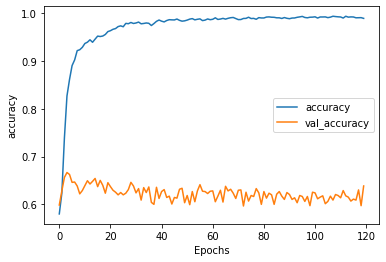

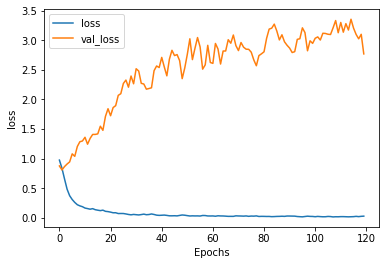

In [54]:
#Define function to plot graph of accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
#Make prediction using X_test
X_test = df_test['tweet']
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, max_length, truncating=trunc_type, padding = 'post')
final_pred = np.argmax(model.predict(X_test))

In [95]:
#View classification report
y_pred = model.predict_classes(X_validation)

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.40      0.38        77
           1       0.75      0.68      0.71       871
           2       0.52      0.61      0.56       483
           3       0.00      0.00      0.00        24

    accuracy                           0.63      1455
   macro avg       0.41      0.42      0.41      1455
weighted avg       0.64      0.63      0.63      1455

